#Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg16
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
# ignore warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
%matplotlib inline

In [2]:
!pip install pytorch_msssim

In [3]:
import pytorch_msssim

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#Data Loading

In [5]:
# image plottiong
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
def nameFiles(image_dir, dir):
  _files = []
  with open(dir) as files:
    for line in files:
      _files += [''.join([image_dir, '/', line[:-1], '.jpg'])]
  return _files

In [7]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/VOC12_images/JPEGImages.zip'

In [8]:
all_image_files = sorted(list(Path('/content/JPEGImages').rglob('*.jpg')))
print('num all im_files : {}'.format(len(all_image_files)))

num all im_files : 17125


In [9]:
image_dir = '/content/JPEGImages'
train_files = nameFiles(image_dir, 
                        '/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/train.txt')
train_files += nameFiles(image_dir, 
                        '/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/train_act.txt')
val_files = nameFiles(image_dir, 
                      '/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/val.txt')
val_files += nameFiles(image_dir, 
                      '/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/val_act.txt')

In [10]:
# unique check 
if len(train_files) == len(set(train_files)):
  print('train -- ok')
if len(val_files) == len(set(val_files)):
  print('val -- ok')

train -- ok
val -- ok


In [11]:
print('train_num : {}\nval_num : {}'.format(len(train_files), len(val_files)))

train_num : 8013
val_num : 8115


In [12]:
# let's make val_num = (some small) * train_num
np.random.seed(42)
# get random set
ind_rate = np.random.choice(len(val_files), int(len(val_files) * 0.9))
# add new images
train_files += [val_files[i] for i in ind_rate]
# get still 
stil_val_files = set(np.arange(len(val_files))) - set(ind_rate)
val_files = [val_files[i] for i in stil_val_files]
 
print('train_num : {}\nval_num : {}'.format(len(train_files), len(val_files)))

train_num : 15316
val_num : 3368


#Make DataSet

In [13]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
hr_shape = (256, 256)

In [14]:
class ImageDataset(Dataset):
  def __init__(self, files, hr_shape, upscaling=4):
    hr_height, hr_width = hr_shape
    # Transforms for low resolution images and high resolution images
    self.lr_transform = transforms.Compose([
                                            transforms.Resize((hr_height // upscaling, hr_height // upscaling), 
                                                              interpolation=Image.BICUBIC),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean, std)
                                            ])
    self.hr_transform = transforms.Compose([
                                            transforms.Resize((hr_height, hr_height), 
                                                              interpolation=Image.BICUBIC),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean, std)])
    self.files = files
    
  def __getitem__(self, index):
    img = Image.open(self.files[index % len(self.files)])
    img_lr = self.lr_transform(img)
    img_hr = self.hr_transform(img)
    return {"lr": img_lr, "hr": img_hr}
 
  def __len__(self):
    return len(self.files)

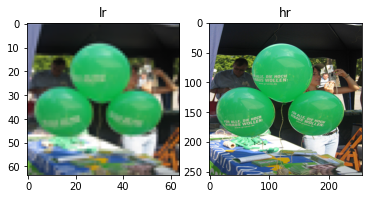

In [15]:
images = ImageDataset(val_files, hr_shape=hr_shape)[-1]
_, ax = plt.subplots(ncols=2)
for i, key in enumerate(images.keys()):
  imshow(images[key].cpu(), 
         title=key,
         plt_ax=ax[i])

#SRGAN architecture

paper: https://arxiv.org/pdf/1609.04802.pdf

![model[1].jpeg](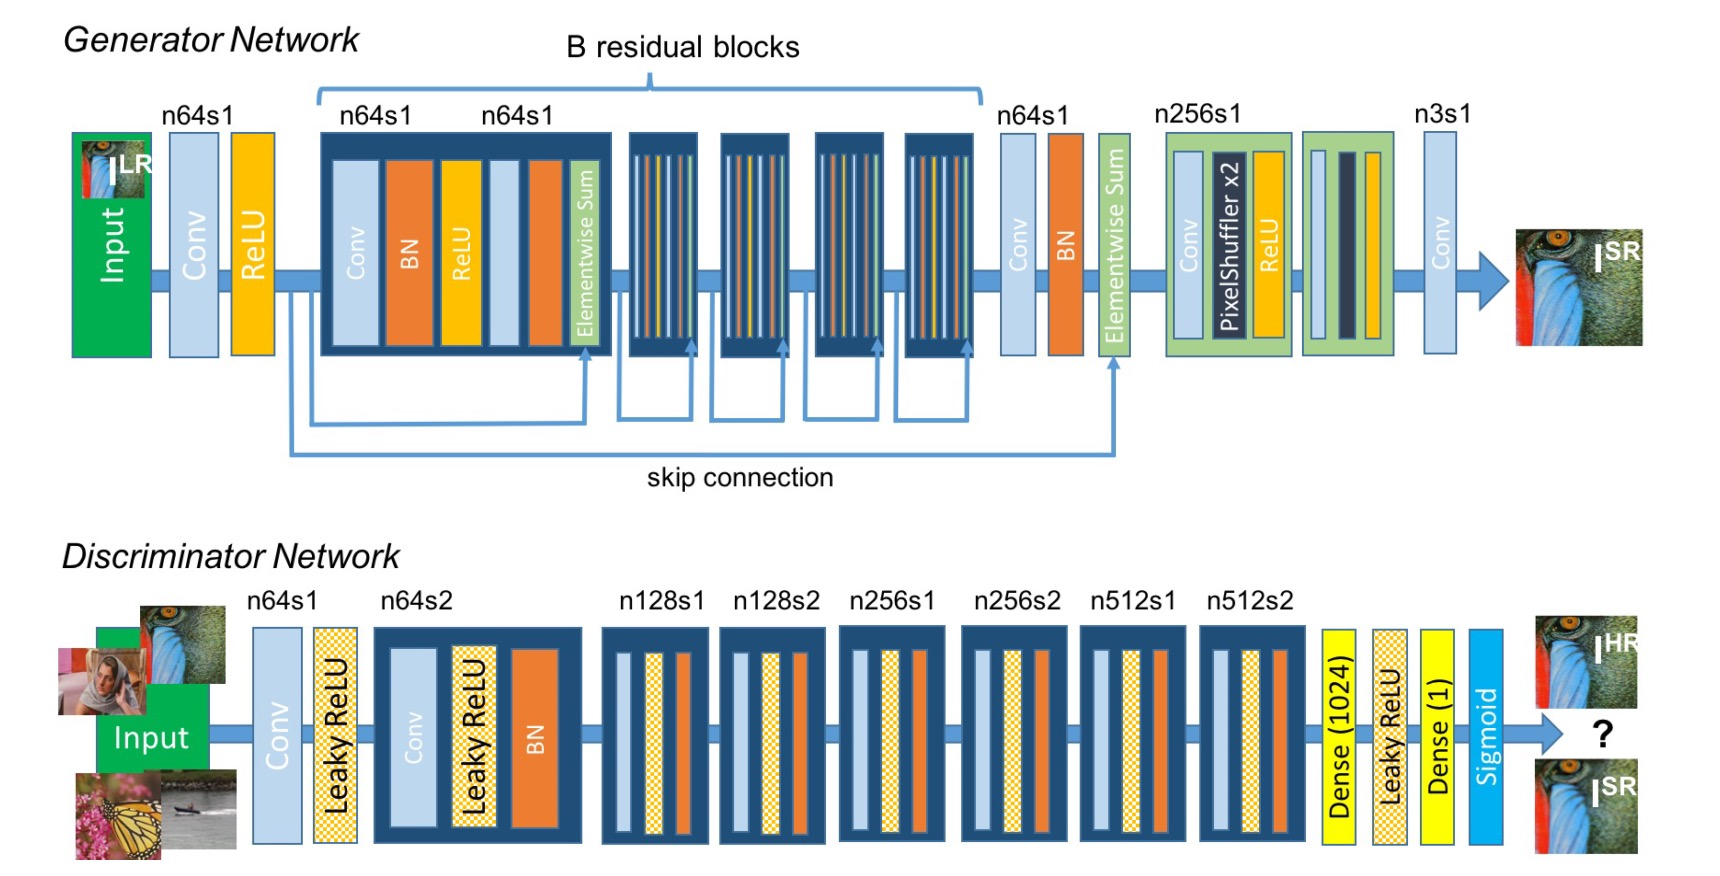)

In [16]:
class FeatureExtractor(nn.Module):
    def __init__(self, cnn):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(cnn.features.children())[:18])
 
    def forward(self, x):
        return self.features(x)

In [17]:
class ResidualBlock(nn.Module):
  def __init__(self, in_features):
    super(ResidualBlock, self).__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(in_features), #0.8
        nn.PReLU(),
        nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(in_features),
        )
 
  def forward(self, x):
    return x + self.conv_block(x)

class UpsampleBLock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBLock, self).__init__()
    self.up_block = nn.Sequential(nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1),
                              nn.PixelShuffle(up_scale),
                              nn.PReLU())

  def forward(self, x):
    return self.up_block(x)

In [18]:
class Generator(nn.Module):
  def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
    super(Generator, self).__init__()
	
    # First layer
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())
    
    # Residual blocks
    res_blocks = []
    for _ in range(n_residual_blocks):
      res_blocks.append(ResidualBlock(64))
    self.res_blocks = nn.Sequential(*res_blocks)
    
    # Second conv layer post residual blocks
    self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))
    
    # Upsampling layers
    upsampling = []
    for out_features in range(2):
      upsampling += [
        nn.Conv2d(64, 256, 3, 1, 1),
        nn.BatchNorm2d(256),
        nn.PixelShuffle(upscale_factor=2),
        nn.PReLU(),
      ]
    self.upsampling = nn.Sequential(*upsampling)
    
    # Final output layer
    self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())
	
  def forward(self, x):
    out1 = self.conv1(x)
    out = self.res_blocks(out1)
    out2 = self.conv2(out)
    out = torch.add(out1, out2)
    out = self.upsampling(out)
    out = self.conv3(out)
    return out

In [19]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
 
    self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
 
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
 
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
 
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
 
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
 
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
 
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
 
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
 
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )
 
  def forward(self, x):
    batch_size = x.size(0)
    return self.net(x), torch.sigmoid(self.net(x).view(batch_size)) # logits, labels

#Train SRGAN

## Train loop

In [20]:
def fit_epoch(data_loader, generator, discriminator, optimizer_G, optimizer_D,
              feature_extractor, criterion_GAN, criterion_content, mode):

  results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': []}
  MSSSIM = []

  with tqdm(desc="batch_num", total=len(data_loader)) as pbar_outer:
    for batch_idx, imgs in enumerate(data_loader):

      # Configure model input
      img_lr = Variable(imgs["lr"].to(device))
      real_img_hr = Variable(imgs["hr"].to(device))
      batch_size = img_lr.size(0)

      #------------------------------------------------------------------------- 
      ## For training  
      #------------------------------------------------------------------------- 
      if mode == 'train':
        generator.train(); discriminator.train()
        _results = {'d_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

        #======================================================================================
        ### Train Generator : maximize D(x) + (1 - D(G(z)))
        #======================================================================================
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_img_hr = generator(img_lr)

        _, f_label = discriminator(gen_img_hr)
        _, r_label = discriminator(real_img_hr)
        # Adversarial ground truths
        valid = Variable(torch.ones_like(r_label, dtype=torch.float).to(device), requires_grad=False)
        fake = Variable(torch.zeros_like(f_label, dtype=torch.float).to(device), requires_grad=False)

        # Adversarial loss
        loss_GAN = criterion_GAN(f_label, valid)
        # Content loss
        gen_features = feature_extractor(gen_img_hr)
        real_features = feature_extractor(real_img_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        #======================================================================================
        ### Train Discriminator : minimize 1 - D(G(z))
        #======================================================================================
        optimizer_D.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_img_hr = generator(img_lr)

        _, f_label = discriminator(gen_img_hr)

        # Loss of real and fake images
        loss_real = criterion_GAN(r_label, valid)
        loss_fake = criterion_GAN(f_label, fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # loss for current batch 
        _results['g_loss'] += loss_G.item()
        _results['d_loss'] += loss_D.item()
        _results['d_score'] += r_label.mean().item()
        _results['g_score'] += f_label.mean().item()

        tqdm.write('Loss_D: %.4f; Loss_G: %.4f; D(x): %.4f; D(G(z)): %.4f' % (
                                _results['d_loss'],
                                _results['g_loss'],
                                _results['d_score'],
                                _results['g_score'])) # to show immediately the update
        pbar_outer.update(1)                  
        
        results['d_loss'].append(_results['d_loss'])
        results['g_loss'].append(_results['g_loss'])
        results['d_score'].append(_results['d_score'])
        results['g_score'].append(_results['g_score'])
      
      #-------------------------------------------------------------------------   
      ## For validation
      #------------------------------------------------------------------------- 
      elif mode == 'val':
        generator.eval(); discriminator.eval()
        _results = {'d_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0, 
                          'msssim': 0}
        with torch.no_grad():

          #===============================================================================================
          ### Eval Generator loss
          #===============================================================================================
          gen_img_hr = generator(img_lr)

          _, f_label = discriminator(gen_img_hr)
          _, r_label = discriminator(real_img_hr)
          # Adversarial ground truths
          valid = Variable(torch.ones_like(r_label, dtype=torch.float).to(device), requires_grad=False)
          fake = Variable(torch.zeros_like(f_label, dtype=torch.float).to(device), requires_grad=False)

          # Adversarial loss
          loss_GAN = criterion_GAN(f_label, valid)
          # Content loss
          gen_features = feature_extractor(gen_img_hr)
          real_features = feature_extractor(real_img_hr)
          loss_content = criterion_content(gen_features, real_features.detach())
          # Total loss
          loss_G = loss_content + 1e-3 * loss_GAN

          #===============================================================================================
          ### Eval Disriminator loss
          #===============================================================================================
          # Loss of real and fake images
          loss_real = criterion_GAN(r_label, valid)
          loss_fake = criterion_GAN(f_label, fake)

          # Total loss
          loss_D = (loss_real + loss_fake) / 2

          #===============================================================================================
          ### Result losses 
          #===============================================================================================
          # loss for current batch 
          _results['g_loss'] += loss_G.item()
          _results['d_loss'] += loss_D.item()
          _results['d_score'] += r_label.mean().item()
          _results['g_score'] += f_label.mean().item()
          
          batch_msssim = pytorch_msssim.ms_ssim(gen_img_hr, real_img_hr).item()
          _results['msssim'] += batch_msssim

          tqdm.write('Loss_D: %.4f; Loss_G: %.4f; D(x): %.4f; D(G(z)): %.4f; msssim : %.4f' % (
                                  _results['d_loss'],
                                  _results['g_loss'],
                                  _results['d_score'],
                                  _results['g_score'],
                                  _results['msssim']))
          pbar_outer.update(1)
           
          # random imshow in current batch
          rand_ind = int(np.random.choice(batch_size, 1))
          _, ax = plt.subplots(ncols=3)
          print(img_lr.shape, gen_img_hr.shape)
          titles = ['img_lr', 'gen_img_hr', 'real_img_hr']
          for i, im in enumerate([img_lr[rand_ind], 
                                  gen_img_hr[rand_ind], 
                                  real_img_hr[rand_ind]]):
            imshow(im.cpu(), title=titles[i], plt_ax=ax[i])
          
          # save loss\scores\ssim
          results['d_loss'].append(_results['d_loss'])
          results['g_loss'].append(_results['g_loss'])
          results['d_score'].append(_results['d_score'])
          results['g_score'].append(_results['g_score'])
          MSSSIM.append(_results['msssim'])
  
  return (results, MSSSIM) if mode == 'val' else results

In [21]:
def train(train_files, val_files, SRGANmodel, epochs, batch_size):
    
    train_dataloader = DataLoader(ImageDataset(train_files[:10], hr_shape=hr_shape),
                                  batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(ImageDataset(val_files[:10], hr_shape=hr_shape),
                                batch_size=int(batch_size), shuffle=False)

    criterion_GAN = nn.BCELoss().to(device)
    criterion_content = nn.MSELoss().to(device)
 
    history = []
    log_template = "===Epoch {ep:03d}==="
 
    lr = 3e-3 
    b1 = 0.5 # decay of first order momentum of gradient
    b2 = 0.999 # decay of second order momentum of gradient

    # Optimizers
    optimizer_G = torch.optim.AdamW(SRGANmodel['G'].parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.AdamW(SRGANmodel['D'].parameters(), lr=lr, betas=(b1, b2))

    for epoch in range(epochs):
      
      print(log_template.format(ep=epoch+1))

      tr_results = fit_epoch(train_dataloader, SRGANmodel['G'], SRGANmodel['D'], optimizer_G, optimizer_D,
                             SRGANmodel['FeatExtr'], criterion_GAN, criterion_content, mode='train')
      
      val_results, MSSSIM = fit_epoch(val_dataloader, SRGANmodel['G'], SRGANmodel['D'], optimizer_G, optimizer_D,
                                      SRGANmodel['FeatExtr'], criterion_GAN, criterion_content, mode='val')

      # Save model checkpoints
      torch.save(SRGANmodel['G'].state_dict(), "/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/saved_models/generator.pth")
      torch.save(SRGANmodel['D'].state_dict(), "/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/saved_models/discriminator.pth")

      history.append((tr_results, val_results, MSSSIM))
            
    return history

##Train prosessing

In [22]:
# Initialize generator and discriminator
SRGANmodel = {'G': Generator().to(device),
              'D': Discriminator().to(device),
              'FeatExtr': FeatureExtractor(vgg16(pretrained=True)).eval().to(device)}

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [23]:
# Load pretrained models ТОЛЬКО ПРИ ПЕРВОЙ ЗАГРУЗКЕ!!!!
SRGANmodel['G'].load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/generator.pth"))
#SRGANmodel['D'].load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/discriminator.pth"))

<All keys matched successfully>

In [24]:
child_counter = 0
for child in SRGANmodel['G'].children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

 child 0 is:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (1): PReLU(num_parameters=1)
)
 child 1 is:
Sequential(
  (0): ResidualBlock(
    (conv_block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): ResidualBlock(
    (conv_block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [25]:
class newGenerator(nn.Module):
  def __init__(self):
    super(newGenerator, self).__init__()
	
    # First layer
    self.conv1 = nn.Sequential(list(SRGANmodel['G'].children())[0])
    
    # Residual blocks
    self.res_blocks = nn.Sequential(*list(SRGANmodel['G'].children())[1][:6])
    
    # Second conv layer post residual blocks
    self.conv2 = nn.Sequential(list(SRGANmodel['G'].children())[2])
    
    # Upsampling layers
    self.upsampling = nn.Sequential(*list(SRGANmodel['G'].children())[3])
    
    # Final output layer
    self.conv3 = nn.Sequential(list(SRGANmodel['G'].children())[4])
	
  def forward(self, x):
    out1 = self.conv1(x)
    out = self.res_blocks(out1)
    out2 = self.conv2(out)
    out = torch.add(out1, out2)
    out = self.upsampling(out)
    out = self.conv3(out)
    return out

In [31]:
SRGANmodel['G'] = newGenerator().to(device)
#SRGANmodel['D'] = Discriminator().to(device)

In [26]:
 # let's see used memory
summary(SRGANmodel['G'], (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]          15,616
             PReLU-2         [-1, 64, 256, 256]               1
            Conv2d-3         [-1, 64, 256, 256]          36,928
       BatchNorm2d-4         [-1, 64, 256, 256]             128
             PReLU-5         [-1, 64, 256, 256]               1
            Conv2d-6         [-1, 64, 256, 256]          36,928
       BatchNorm2d-7         [-1, 64, 256, 256]             128
     ResidualBlock-8         [-1, 64, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          36,928
      BatchNorm2d-10         [-1, 64, 256, 256]             128
            PReLU-11         [-1, 64, 256, 256]               1
           Conv2d-12         [-1, 64, 256, 256]          36,928
      BatchNorm2d-13         [-1, 64, 256, 256]             128
    ResidualBlock-14         [-1, 64, 2

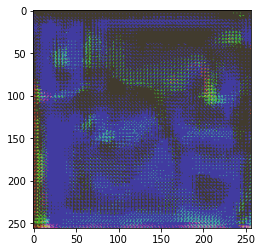

In [32]:
val_dataloader = DataLoader(ImageDataset(val_files[:10], hr_shape=hr_shape),
                                batch_size=3, shuffle=False)
SRGANmodel['G'].eval()
for imgs in val_dataloader:
  img_lr = Variable(imgs["lr"].to(device))
  real_img_hr = Variable(imgs["hr"].to(device))
  gen_im_sr = SRGANmodel['G'](img_lr)
  for i in gen_im_sr:
    imshow(i.detach().cpu())

batch_num:   0%|          | 0/2 [00:00<?, ?it/s]

===Epoch 001===


batch_num:   0%|          | 0/2 [00:00<?, ?it/s]

Loss_D: 0.7134; Loss_G: 158.4534; D(x): 0.5423; D(G(z)): 0.5439
Loss_D: 0.6895; Loss_G: 103.1302; D(x): 0.4520; D(G(z)): 0.4429


batch_num: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Loss_D: 0.1352; Loss_G: 170.8448; D(x): 0.9052; D(G(z)): 0.1112; msssim : 0.9617
torch.Size([9, 3, 64, 64]) torch.Size([9, 3, 256, 256])
Loss_D: 0.0282; Loss_G: 171.0836; D(x): 0.9990; D(G(z)): 0.0538; msssim : 0.9848
torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 256, 256])


batch_num:   0%|          | 0/2 [00:00<?, ?it/s]

===Epoch 002===


batch_num:   0%|          | 0/2 [00:00<?, ?it/s]

Loss_D: 0.9693; Loss_G: 174.3579; D(x): 0.4600; D(G(z)): 0.4266
Loss_D: 0.6962; Loss_G: 149.7854; D(x): 0.5089; D(G(z)): 0.5117


batch_num: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Loss_D: 1.2676; Loss_G: 144.3171; D(x): 0.5207; D(G(z)): 0.4532; msssim : 0.9767
torch.Size([9, 3, 64, 64]) torch.Size([9, 3, 256, 256])
Loss_D: 0.6034; Loss_G: 148.2674; D(x): 0.5910; D(G(z)): 0.4938; msssim : 0.9917
torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 256, 256])


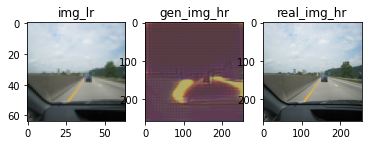

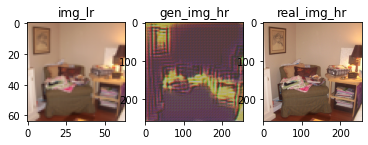

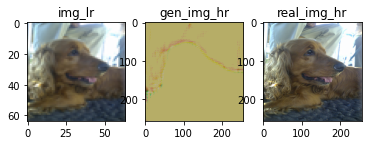

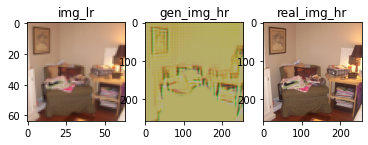

In [36]:
epochs = 2
history = train(train_files, val_files, SRGANmodel, epochs=epochs, batch_size=9)

In [ ]:
torch.save(SRGANmodel['G'].state_dict(), f"/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/saved_models/generator_{epochs}epochs.pth")
torch.save(SRGANmodel['D'].state_dict(), f"/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/saved_models/discriminator_{epochs}epochs.pth")
'''
hist_file = f"/content/drive/MyDrive/Colab Notebooks/DLS_semester1/20.1 Итоговый проект. Telegram Bot/saved_models/history_{epochs}epochs.txt"
with open(hist_file, 'w') as output:
  for line in history:
    output.write(' '.join(map(str, line)) +'\n')
'''

#Train ESRGAN

papers: 

https://arxiv.org/pdf/1809.00219.pdf

https://arxiv.org/pdf/2005.00306.pdf